In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle
from itertools import product

# Save Results

## Load mlflow runs

In [2]:
db_port = 5001
db_name = 'cohirf'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
results_dir = Path.cwd().parent / 'results' / 'scale_features_informative'
os.makedirs(results_dir, exist_ok=True)

In [3]:
experiment_names

['Default',
 'sfni-SpectralSubspaceRandomization',
 'sfni-KMeans',
 'sfni-AffinityPropagation',
 'sfni-CompleteAgglomerativeClustering',
 'sfni-WardAgglomerativeClustering',
 'sfi-AffinityPropagation',
 'sfni-DBSCAN',
 'sfi-AverageAgglomerativeClustering',
 'sfni-CoHiRF',
 'sfi-Clique',
 'sfi-CoHiRF-DBSCAN',
 'sfni-CoHiRF-DBSCAN',
 'sfi-CoHiRF',
 'sfni-Clique',
 'sfi-CompleteAgglomerativeClustering',
 'sfi-DBSCAN',
 'sfni-AverageAgglomerativeClustering',
 'sfi-HDBSCAN',
 'sfni-HDBSCAN',
 'sfi-IRFLLRR',
 'sfni-IRFLLRR',
 'sfi-KMeans',
 'sfni-KMeansProj',
 'sfi-KMeansProj',
 'sfi-MeanShift',
 'sfni-OPTICS',
 'sfni-MeanShift',
 'sfi-OPTICS',
 'sfni-Proclus',
 'sfni-SingleAgglomerativeClustering',
 'sfni-SpectralClustering',
 'sfi-Proclus',
 'sfi-SingleAgglomerativeClustering',
 'sfi-SpectralClustering',
 'sfi-SpectralSubspaceRandomization',
 'sfi-WardAgglomerativeClustering',
 'sphere-AffinityPropagation',
 'sphere-AverageAgglomerativeClustering',
 'sphere-Clique',
 'sphere-CoHiRF-DBSCAN'

In [4]:
experiments_names = [exp for exp in experiment_names if exp.startswith('sfi')]

In [5]:
experiments_names

['sfi-AffinityPropagation',
 'sfi-AverageAgglomerativeClustering',
 'sfi-Clique',
 'sfi-CoHiRF-DBSCAN',
 'sfi-CoHiRF',
 'sfi-CompleteAgglomerativeClustering',
 'sfi-DBSCAN',
 'sfi-HDBSCAN',
 'sfi-IRFLLRR',
 'sfi-KMeans',
 'sfi-KMeansProj',
 'sfi-MeanShift',
 'sfi-OPTICS',
 'sfi-Proclus',
 'sfi-SingleAgglomerativeClustering',
 'sfi-SpectralClustering',
 'sfi-SpectralSubspaceRandomization',
 'sfi-WardAgglomerativeClustering']

In [6]:
params_columns = [
    "model_nickname",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_random",
    "n_informative",
    "n_features_dataset",
    "pct_random",
    "class_sep",
    "seed_unified",
    "n_classes",
]

In [7]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity',
    'completeness',
    'v_measure',
    'silhouette',
    'calinski_harabasz_score',
    'davies_bouldin_score',
    'inertia_score',
    'best_n_clusters_',
    'best_rand_score',
    'best_adjusted_rand',
    'best_mutual_info',
    'best_adjusted_mutual_info',
    'best_normalized_mutual_info',
    'best_homogeneity_completeness_v_measure',
    'best_silhouette',
    'best_calinski_harabasz_score',
    'best_davies_bouldin_score',
    'best_inertia_score',
    'best_homogeneity',
    'best_completeness',
    'best_v_measure',
]

In [8]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'parent_run_id',
    'best_child_run_id',
]

In [9]:
# # parameters of each model, they are saved as tags for the parent run
# parameters = {
#     'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
#     'KMeans': ['n_clusters'],
#     'HDBSCAN': ['min_cluster_size'],
#     'DBSCAN': ['eps', 'min_samples'],
#     'AffinityPropagation': ['damping'],
#     'OPTICS': ['min_samples'],
#     'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
#     'WardAgglomerativeClustering': ['n_clusters'],
# }
# all_model_parameters = [p for model, params in parameters.items() for p in params]
# all_model_parameters = list(set(all_model_parameters))
# for param in all_model_parameters:
#     tags_columns.append(param)

In [10]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [11]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)
df_runs_raw.to_csv(results_dir / 'df_runs_raw.csv', index=True)

In [12]:
df_runs_raw = pd.read_csv(results_dir / "df_runs_raw.csv", index_col=0)
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['parent_run_id'].isna()]

In [13]:
df_runs_raw_parents

,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features_dataset,n_informative,n_random,n_samples,...,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
009d10a017f9407f9d931ef4e7d1e656,FINISHED,1749826798965,1.749827e+12,30.000000,DBSCAN,5,NaN,100,0,1000,...,0.000000,1.0,0.000000,0.199199,-1.000000,0.000000,NaN,59d01b1fd5e44938880393b8c04a2396,NaN,False
00a54a263d9044a6a76e697d3a23482d,FINISHED,1749827015167,1.749827e+12,300.000000,CoHiRF,5,NaN,10000,0,1000,...,1.609438,5.0,1.000000,1.000000,0.810026,1.000000,NaN,341146d69f5242b18755356edddd3695,NaN,False
01060b071ec543a4ada04a24444a2018,FINISHED,1749836227593,1.749837e+12,94.868330,MeanShift,5,NaN,1000,0,1000,...,0.000000,1.0,0.000000,0.199199,-1.000000,0.000000,NaN,531084f9da12402b89785d08eb027b70,NaN,False
013e0303e7234a28a4d6ab86bffc1e65,FINISHED,1749825802992,1.749826e+12,5.196152,AverageAgglomerativeClustering,5,NaN,3,0,1000,...,1.609438,8.0,0.992666,0.998414,0.634682,0.992666,NaN,2694e9bccf9f499496f7c3b2c730fb40,NaN,False
01bdc8e9fc924ddb8573a35e7a55e116,FINISHED,1749837956078,1.749838e+12,30.000000,MeanShift,5,NaN,100,0,1000,...,0.000000,1.0,0.000000,0.199199,-1.000000,0.000000,NaN,ee84a0eed34b4e08afef84c0e9c58853,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feb6263540db4cf2a96ff821a782008a,FINISHED,1749830205883,1.749830e+12,30.000000,SpectralClustering,5,NaN,100,0,1000,...,0.053137,30.0,0.029086,0.668877,-0.775743,0.029086,NaN,b475535a75bc46f489e56086fa53595f,NaN,False
feecbf3d85d64f47982bd397d2cbc36f,FINISHED,1749829326159,1.749829e+12,5.196152,SpectralClustering,5,NaN,3,0,1000,...,1.609438,6.0,0.965319,0.984402,0.728988,0.965319,NaN,2dc9584b7d564a1db7beaa1f33df8689,NaN,False
ff577ad1fb684c53a2bc93d54b1c179e,FINISHED,1749946286832,1.749949e+12,30.000000,IRFLLRR,5,NaN,100,0,1000,...,1.603137,5.0,0.996087,0.999201,0.801342,0.996087,NaN,66e245c2dd504542bc4f513b4f089b13,NaN,False


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [14]:
non_duplicate_columns = [
    "model_nickname",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_random",
    "n_informative",
    "n_features_dataset",
    "pct_random",
    "class_sep",
    "seed_unified",
    "n_classes",
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how="all", subset=["best_adjusted_rand"]).copy()
# fill missing values with "None"
df_runs_parents = df_runs_parents.fillna("None")
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]

/tmp/ipykernel_181210/317284592.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_runs_parents = df_runs_parents.fillna("None")


# Missing

In [15]:
model_nickname = df_runs_parents['model_nickname'].unique().tolist()
model_nickname.sort()
model_nickname

['AffinityPropagation',
 'AverageAgglomerativeClustering',
 'Clique',
 'CoHiRF',
 'CoHiRF-DBSCAN',
 'CompleteAgglomerativeClustering',
 'DBSCAN',
 'HDBSCAN',
 'IRFLLRR',
 'KMeans',
 'KMeansProj',
 'MeanShift',
 'OPTICS',
 'Proclus',
 'SingleAgglomerativeClustering',
 'SpectralClustering',
 'SpectralSubspaceRandomization',
 'WardAgglomerativeClustering']

In [16]:
model_nickname = [
	'AffinityPropagation',
	'AverageAgglomerativeClustering',
	# 'Clique',
	'CoHiRF',
	'CoHiRF-DBSCAN',
	'CompleteAgglomerativeClustering',
	'DBSCAN',
	'HDBSCAN',
	'IRFLLRR',
	'KMeans',
	# 'KMeansProj',
	'MeanShift',
	'OPTICS',
	'Proclus',
	'SingleAgglomerativeClustering',
	'SpectralClustering',
	'SpectralSubspaceRandomization',
	'WardAgglomerativeClustering'
 ]

In [17]:
non_duplicate_columns = [
    "model_nickname",
    "n_informative",
    "class_sep",
	"seed_unified",
]

In [18]:
n_informative = [3, 10, 100, 1000, 10000]
class_sep = [5.196152422706632, 9.486832980505138, 30.0, 94.86832980505136, 300.0]
seed_unified = [i for i in range(10)]
seed_unified_model = list(product(seed_unified, model_nickname))

combinations_keys = non_duplicate_columns
combinations = list(zip(n_informative, class_sep))
combinations = [(model, n, sep, seed) for (n, sep) in combinations for (seed, model) in seed_unified_model]
combinations_list = [dict(zip(combinations_keys, values)) for values in combinations]

df_combinations = pd.DataFrame(combinations_list)
# Ensure types match for comparison
for col in non_duplicate_columns:
	if col in df_runs_parents.columns:
		df_combinations[col] = df_combinations[col].astype(df_runs_parents[col].dtype)
# Find missing rows
merged = df_combinations.merge(
	df_runs_parents[non_duplicate_columns],
	on=non_duplicate_columns,
	how='left',
	indicator=True
)
df_missing = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
df_missing.sort_values(by=non_duplicate_columns, inplace=True)
df_missing = df_missing.rename(columns={'seed_unified': 'seeds_unified'})

In [19]:
# Join df_runs_raw_parents into df_missing using non_duplicate_columns to get the EXCEPTION column
df_missing_with_exception = df_missing.merge(
	df_runs_raw_parents[non_duplicate_columns + ['EXCEPTION']],
	how='left',
	left_on=['model_nickname', 'n_informative', 'class_sep', 'seeds_unified'],
	right_on=['model_nickname', 'n_informative', 'class_sep', 'seed_unified']
)
df_missing_with_exception[['model_nickname', 'n_informative', 'class_sep', 'seeds_unified', 'EXCEPTION']]

,model_nickname,n_informative,class_sep,seeds_unified,EXCEPTION
0,IRFLLRR,1000,94.86833,3,'adjusted_rand'


In [20]:
df_missing

,model_nickname,n_informative,class_sep,seeds_unified
535,IRFLLRR,1000,94.86833,3


In [21]:
df_missing.model_nickname.unique()

array(['IRFLLRR'], dtype=object)

In [22]:
missing_dict = {}
for model in df_missing['model_nickname'].unique():
	sub = df_missing[df_missing['model_nickname'] == model].drop(columns=['model_nickname'])
	missing_dict[model] = sub.to_dict(orient='records')
if len(missing_dict) != 0:
    with open(results_dir / 'missing_dict.pkl', 'wb') as f:
        pickle.dump(missing_dict, f)

In [23]:
missing_dict

{'IRFLLRR': [{'n_informative': 1000,
   'class_sep': 94.86832980505136,
   'seeds_unified': 3}]}

# Get common combinations

In [24]:
model_nickname = [
    "AffinityPropagation",
    "AverageAgglomerativeClustering",
    # "Clique",
    "CoHiRF",
    "CoHiRF-DBSCAN",
    "CompleteAgglomerativeClustering",
    "DBSCAN",
    "HDBSCAN",
    "IRFLLRR",
    "KMeans",
    # "KMeansProj",
    "MeanShift",
    "OPTICS",
    "Proclus",
    "SingleAgglomerativeClustering",
    "SpectralClustering",
    "SpectralSubspaceRandomization",
    "WardAgglomerativeClustering",
]
df = df_runs_parents.copy()
df = df.loc[df["model_nickname"].isin(model_nickname)]
column = "model_nickname"
combination_columns = [
    "seed_unified",
    "n_informative",
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [25]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [26]:
df_common["n_samples"] = df_common["n_samples"].astype(int)
df_common["n_informative"] = df_common["n_informative"].astype(int)

In [27]:
# Join df_common with df_runs_raw to get the time of best_child_run_id
df_common["best_child_time"] = df_common["best_child_run_id"].map(df_runs_raw["fit_model_return_elapsed_time"])

# Plots

## HPO Time -> NOT INTERESTING

/tmp/ipykernel_181210/2262596789.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


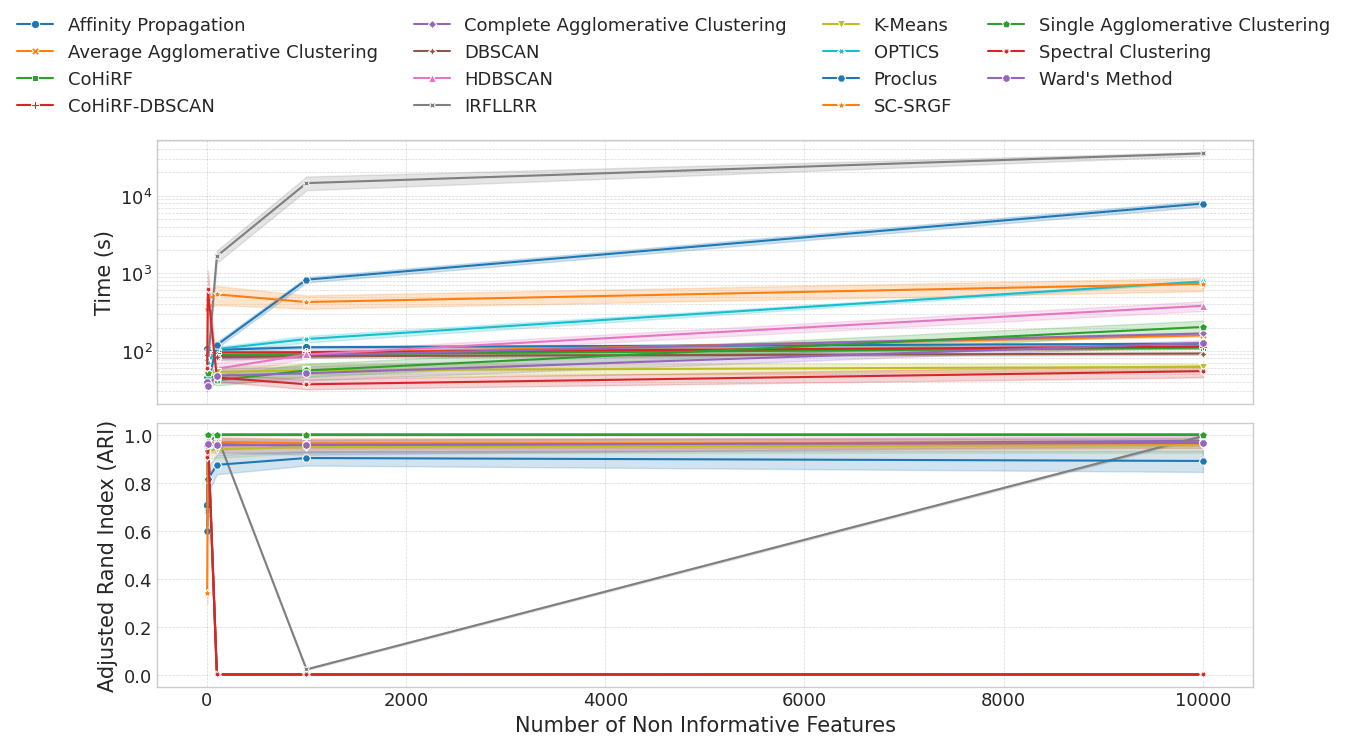

In [30]:
import matplotlib.ticker as mticker

df = df_common.copy()
n_samples = 1000
models_names = {
    "AffinityPropagation": "Affinity Propagation",
    "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    "DBSCAN": "DBSCAN",
    "HDBSCAN": "HDBSCAN",
    "IRFLLRR": "IRFLLRR",
    "KMeans": "K-Means",
    "OPTICS": "OPTICS",
    "Proclus": "Proclus",
    "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    "SpectralClustering": "Spectral Clustering",
    "SpectralSubspaceRandomization": "SC-SRGF",
    "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["n_samples"] == n_samples]
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
df = df.rename(
    columns={
        "fit_model_return_elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "n_informative": "Number of Informative Features",
        "model_nickname": "Model",
        "best_adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of Informative Features",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of Informative Features",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of Non Informative Features")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.savefig(
        results_dir / f"hpo_non_informative_features_n-informative_{n_informative}_n-samples_{n_samples}_all.pdf",
        dpi=300,
    )
    plt.show()

# Debug and explore

In [56]:
df_runs_raw

,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features_dataset,n_informative,n_random,n_samples,...,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
0001bea6d6da411784daaab6f015c989,FINISHED,1749825964198,1.749826e+12,94.868330,AffinityPropagation,5,NaN,1000,0,1000,...,1.609438,5.0,1.000000,1.000000,0.808197,1.000000,NaN,NaN,4ea315a4d8d74eb1823e5685fb002252,False
00028fe00a264989b4b816ef9831060b,FINISHED,1749855332923,1.749855e+12,300.000000,Clique,5,NaN,10000,0,1000,...,0.000000,1.0,0.000000,0.199199,-1.000000,0.000000,NaN,NaN,afe2a93f1f964328b2ea7a8be16f0ed2,False
00066b8693de431eb5efad7f275debfe,FINISHED,1749833177305,1.749833e+12,9.486833,Clique,5,NaN,10,0,1000,...,0.627922,7.0,0.400873,0.724619,-0.127914,0.400873,NaN,NaN,c2d7916a47b74a2db95fea512a72e811,False
000e0cb2c001401f9428dab944af0417,FINISHED,1749840634585,1.749841e+12,300.000000,Clique,5,NaN,10000,0,1000,...,0.000000,1.0,0.000000,0.199199,-1.000000,0.000000,NaN,NaN,587dc3e46bfc4760bc477947f2986b42,False
00181c255d1b45e7ad0470a8ba94d24e,FINISHED,1749828215771,1.749828e+12,94.868330,Proclus,5,NaN,1000,0,1000,...,1.504113,27.0,0.637982,0.839878,-0.081599,0.637982,NaN,NaN,3c32898b4e734c9b80c1fa62ca8c873a,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff6df237aee469ea310e0274f982f87,FINISHED,1749829936125,1.749830e+12,30.000000,SingleAgglomerativeClustering,5,NaN,100,0,1000,...,1.609438,14.0,0.982709,0.996424,0.107424,0.982709,NaN,NaN,0c66e1951b89417886340f4943059fc1,False
fff743d9e1694368ae7d89e9178b10b7,FINISHED,1749829719636,1.749830e+12,300.000000,SingleAgglomerativeClustering,5,NaN,10000,0,1000,...,1.609438,29.0,0.955253,0.990565,0.162898,0.955253,NaN,NaN,ba794c7c7d224b89b76805c30a8e77c9,False
fffb3017bb9243a68cb4ae3cfd58fd50,FINISHED,1749829722945,1.749830e+12,300.000000,SpectralClustering,5,NaN,10000,0,1000,...,0.039769,22.0,0.026962,0.502901,-0.657593,0.026962,NaN,NaN,5bda55755bae45b39b16b6a815b9bfcc,False


In [82]:
df = df_runs_raw.copy()
df = df.loc[df['model_nickname'] == 'Proclus']

In [83]:
runs_to_delete = list(df.index)
runs_to_delete

['0fb3835a083447139cb1917a5ec27dfe',
 '18c2759607ca4548a4c10b040547c993',
 '23a991341fb54936be83c8d868f99286',
 '29270b3c8ba6432e830f9cf32e47f546',
 '2bb6ee359f6c46eba2722a29fda501ae',
 '2f6c4691b3814f64aaec01097547aa6c',
 '3fa955cb725b4137bcbbb03f4d83af1b',
 '415cfc934a5a44b59654a9a48e8c84ca',
 '41c016aa2323418b99c40804b359f9ed',
 '4b1fa857d32e4b0886ddfee5d88d984f',
 '51d372a5ee8a419683e0ce6631c67c39',
 '5210a2aba1b144ed863b6c299e2e4d7c',
 '5aecd124023e477b8822b6ad6093c228',
 '643507437a7b4d87b6b3a559ef40d163',
 '66eae303d28a4631baa5443acf869d82',
 '6e24c682a4094c49a91079944f43ddf7',
 '74be4e6a2ffa48078a29af02bfff403d',
 '7ecb6a580d244787813445aa80e8561c',
 '80ae4520da964b5bbd49bbe27f4952da',
 '811b2597ef1f430e907b73da8abfc338',
 '8324872078514b7eb13a4957431cc447',
 '8677be5231a24c62985d00cf8ba0346d',
 '8f318cbdde684a6194f8775ae3bb9e9c',
 '92221ee3c2cf4793a02f24d43f91a9f4',
 '928d2c10964d48c98a241b9f248a72ce',
 '96e26789844342f29092d08dd9b2839c',
 '9713d0338b2f4f1382161654eccb69eb',
 

In [84]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [85]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

In [86]:
query = f"""
DELETE
FROM
	experiment_tags
WHERE
	experiment_id = ANY(
	SELECT
		experiment_id
	FROM
		experiments
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	latest_metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	params
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	tags
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE 
FROM 
	runs
WHERE 
	lifecycle_stage = 'deleted';

DELETE 
FROM 
	experiments
WHERE 
	lifecycle_stage = 'deleted';
"""
with engine.begin() as conn:
    conn.execute(text(query))